<a href="https://colab.research.google.com/github/preetamjumech/Quantization/blob/main/Quantization_TF_01_01_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [5]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [6]:
len(X_train)

60000

In [7]:
len(X_test)

10000

In [8]:
X_train[0].shape

(28, 28)

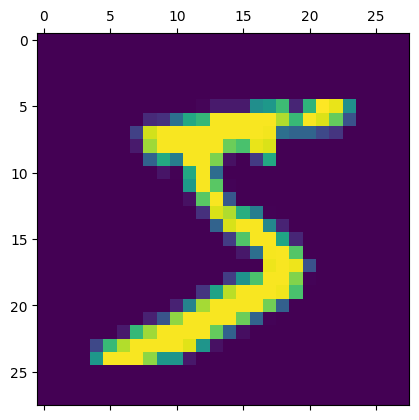

In [9]:
plt.matshow(X_train[0])

In [10]:
y_train[0]

5

In [11]:
X_train = X_train / 255
X_test = X_test / 255

In [12]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [13]:
X_train_flattened.shape

(60000, 784)

In [21]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2770 - accuracy: 0.9212
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1264 - accuracy: 0.9623
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0887 - accuracy: 0.9729
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0674 - accuracy: 0.9788
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0516 - accuracy: 0.9837


In [12]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9729 - loss: 0.0921


[0.08139323443174362, 0.9760000109672546]

In [14]:
tf.saved_model.save(model, "/content/my_model")

# (1) Post training quantization

In [22]:
import tensorflow as tf


# converter = tf.lite.TFLiteConverter.from_saved_model("/content/my_model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

### With Quantization

In [23]:
import tensorflow as tf

# converter = tf.lite.TFLiteConverter.from_saved_model("model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [24]:
len(tflite_model)

319956

In [25]:
len(tflite_quant_model)

86016

In [26]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [27]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

# (2) Quantization aware training

In [2]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.2 MB/s eta 0:00:00


In [15]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 100)               78505     
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                1015      
 pperV2)                                                         
                                                                 
Total params: 79524 (310.64 KB)
Trainable params: 79510 

In [16]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 13s 6ms/step - loss: 0.0449 - accuracy: 0.9862


In [17]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0808 - accuracy: 0.9753


[0.08077739924192429, 0.9753000140190125]

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [19]:
len(tflite_qaware_model)

82704

In [20]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)